In [1]:
import os
import jax
import pickle

os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=24'
jax.config.update('jax_platform_name', 'cpu')

#from jax.config import config; config.update("jax_enable_x64", True)

%load_ext autoreload
%autoreload 2

from brax import envs
from brax.io import html, model
from brax.training import normalization

import flax
import jax.numpy as jnp
from brax.envs import create_fn

from IPython.display import HTML, clear_output

import optax

import matplotlib.pyplot as plt
import numpy as np

from controllers import GruController, MlpController, LinearController

from ce_apg import do_one_rollout, cem_apg

from functools import partial

def visualize(sys, qps, height=480):
  """Renders a 3D visualization of the environment."""
  return HTML(html.render(sys, qps, height=height))

len(jax.devices())

save_dir = "save_ce_apg_pend2"

0.001668568


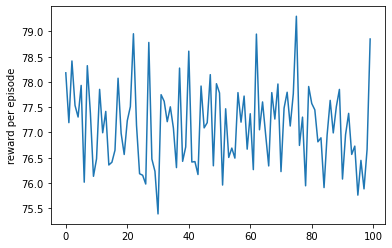

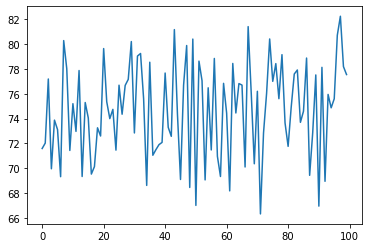

 Iteration 99 --------------------------------
0 : reward: 71.133544921875 -> 78.8508529663086
1 : reward: 77.93528747558594 -> 75.76831817626953
2 : reward: 67.54299926757812 -> 75.6604232788086
3 : reward: 72.08369445800781 -> 75.50835418701172
4 : reward: 72.88249206542969 -> 74.90277862548828
5 : reward: 75.82710266113281 -> 74.60676574707031
6 : reward: 68.81039428710938 -> 74.46585845947266
7 : reward: 79.88807678222656 -> 74.31758117675781
---
8 : reward: 69.74740600585938 -> 74.08314514160156
9 : reward: 68.80232238769531 -> 73.8858413696289
10 : reward: 71.6633071899414 -> 73.55245208740234
11 : reward: 75.99881744384766 -> 73.50878143310547
12 : reward: 74.84063720703125 -> 73.42822265625
13 : reward: 82.80001068115234 -> 73.41230010986328
14 : reward: 71.5453109741211 -> 73.10771942138672
15 : reward: 77.57070922851562 -> 72.54631042480469
16 : reward: 76.24220275878906 -> 72.4406509399414
17 : reward: 82.1413345336914 -> 71.832763671875
18 : reward: 73.43437194824219 -> 71.

In [3]:
for env_name in ["acrobot", "inverted_pendulum_swingup", "inverted_double_pendulum_swingup"]: # "acrobot", "inverted_pendulum_swingup", "inverted_double_pendulum_swingup"]:
    episode_length = 500
    action_repeat = 1
    env_fn = create_fn(env_name = env_name, episode_length=episode_length, action_repeat=action_repeat, batch_size=None, auto_reset=False)
    env = env_fn()

    policy_size = int(2**jnp.ceil(jnp.log2(env.observation_size*4)))
    print(policy_size)
    policy = GruController(env.observation_size, env.action_size, policy_size)
    pickle.dump(policy, open(f"{save_dir}/{env_name}_policy", 'wb'))
    
    for i in range(8):
        inference_fn, params, rewards = cem_apg(env_fn,
                                                100,
                                                key=jax.random.PRNGKey(i),
                                                episode_length = episode_length,
                                                action_repeat = action_repeat,
                                                apg_epochs = 100,
                                                batch_size = 1,
                                                zero_params=True,
                                                truncation_length = None,
                                                learning_rate = 3e-4,
                                                clipping = 1e9,
                                                initial_std = 0.05,
                                                num_elite = 8,
                                                eps = 0.0,
                                                normalize_observations=True,
                                                policy = policy,
                                                learning_schedule = [-3, -6]
                                               )

        model.save_params(f"{save_dir}/{env_name}_params_{i}", params)
        pickle.dump(rewards, open(f"{save_dir}/{env_name}_rewards.pkl{i}", "wb"))



In [4]:
from brax.io import model
import ce_apg

env_name = 'acrobot'
episode_length = 500
action_repeat = 1
env_fn = create_fn(env_name = env_name, episode_length=episode_length, action_repeat=action_repeat, batch_size=None, auto_reset=False)
env = env_fn()

# model.save_params('/tmp/params', params)
# inference_fn = ce_apg.make_inference_fn(
#     env.observation_size, env.action_size, True, policy)
# params = model.load_params('/tmp/params')

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
#jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=0)
state = jit_env_reset(rng=rng)
h = np.zeros_like(state.obs)

r = []
while not state.done:
  rollout.append(state)
  r.append(state.reward)
  #h, act = jit_inference_fn(params, h, state.obs)
  act = jnp.ones(1)
  state = jit_env_step(state, act)

print(sum(r))
HTML(html.render(env.sys, [s.qp for s in rollout]))

-319.9921


In [ ]:
# env_name = "acrobot"  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'walker2d, 'ur5e', 'reacher', bball_1dof]

# episode_length = 500
# action_repeat = 1
# env_fn = create_fn(env_name = env_name, action_repeat=action_repeat, batch_size=None, auto_reset=False)
# env = env_fn()



# policy_size = int(2**jnp.ceil(jnp.log2(env.observation_size*4)))
# print(policy_size)
# policy = GruController(env.observation_size, env.action_size, 32)

# for i in range(8):
#     normalizer_params, policy_params, rewards = cem_apg(env_fn,
#                                                         200,
#                                                         key=jax.random.PRNGKey(i),
#                                                         episode_length = episode_length,
#                                                         action_repeat = action_repeat,
#                                                         apg_epochs = 75,
#                                                         cem_epochs = 1,
#                                                         batch_size = 1,
#                                                         truncation_length = None,
#                                                         learning_rate = 5e-4,
#                                                         clipping = 1e9,
#                                                         initial_std = 0.01,
#                                                         num_elite = 8,
#                                                         eps = 0.0,
#                                                         normalize_observations=True,
#                                                         policy = policy
#                                                        )



#     pickle.dump(policy_params, open(f"{save_dir}/{env_name}_policy{i}.pkl", 'wb'))
#     pickle.dump(normalizer_params, open(f"{save_dir}/{env_name}_normalize{i}.pkl", 'wb'))
#     pickle.dump(rewards, open(f"{save_dir}/{env_name}_rewards.pkl{i}", 'wb'))

In [ ]:
# env_name = "inverted_double_pendulum_swingup"  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'walker2d, 'ur5e', 'reacher', bball_1dof]

# episode_length = 500
# action_repeat = 1
# env_fn = create_fn(env_name = env_name, action_repeat=action_repeat, batch_size=None, auto_reset=False)
# env = env_fn()



# policy_size = int(2**jnp.ceil(jnp.log2(env.observation_size*4)))
# print(policy_size)
# policy = GruController(env.observation_size, env.action_size, 128)

# for i in range(8):
#     normalizer_params, policy_params, rewards = cem_apg(env_fn,
#                                                         200,
#                                                         key=jax.random.PRNGKey(i),
#                                                         episode_length = episode_length,
#                                                         action_repeat = action_repeat,
#                                                         apg_epochs = 75,
#                                                         cem_epochs = 1,
#                                                         batch_size = 1,
#                                                         truncation_length = None,
#                                                         learning_rate = 5e-4,
#                                                         clipping = 1e9,
#                                                         initial_std = 0.01,
#                                                         num_elite = 8,
#                                                         eps = 0.0,
#                                                         normalize_observations=True,
#                                                         policy = policy
#                                                        )



#     pickle.dump(policy_params, open(f"{save_dir}/{env_name}_policy{i}.pkl", 'wb'))
#     pickle.dump(normalizer_params, open(f"{save_dir}/{env_name}_normalize{i}.pkl", 'wb'))
#     pickle.dump(rewards, open(f"{save_dir}/{env_name}_rewards.pkl{i}", 'wb'))

In [ ]:
# import pickle
# pickle.dump(policy_params2, open("inverted_double_pendulum_swingup.pickle", 'wb'))

In [ ]:
# env_name = "inverted_double_pendulum_swingup"
# pickle.dump(policy_params2, open(f"{env_name}_policy.pkl", 'wb'))
# pickle.dump(normalizer_params2, open(f"{env_name}_normalize.pkl", 'wb'))
# pickle.dump(rewards2, open(f"{env_name}_rewards.pkl", 'wb'))